In [1]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil
%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
model.load_weights('data_gen_test_KUpatients.h5')

In [3]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [4]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_K' in f:
        continue
      else:
        images.append(f)
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [5]:
def visualise_data_pred(x):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    #contours = measure.find_contours(y[50*i,:,:,0], .99)
    #for contour in contours:
      #ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

In [6]:
def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

def retrieve_images_for_prediction(data_path, images,num, size=(512,512)):
  x = []
  for i in range(num):
    img = read_nifti_file(data_path+'\\'+images[i])
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(img.shape[-1]):
      x.append(img[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]

  return x

In [9]:
data_path = r'C:\Users\UAB\data\KU-NPY'
images = gather_images(data_path)

In [8]:
print(images[0])
print(len(images))
print(images[0:2])

train
2
['train' 'valid']


In [10]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

We need to gather a stack of 32 images for the prediction in the shape (32, 512, 512, 1)


In [11]:
image = np.load(data_path +"\\"+images[2])
image.shape
image_stack = np.empty((32,512,512,1))
image_stack.shape
label_match = images[0][:-5] + 'K.npy'
print(label_match)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [54]:
image_stack[1,...,0] = image[...]
print(image_stack.shape)

(32, 512, 512, 1)


In [68]:
image_names = images[0:31]
image_stack = np.empty((32,512,512,1))
label_list = []
for i in range(len(image_names)):
    image = np.load(data_path +"\\"+images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(images[i][:-5] + 'K.npy')
    label_list.append(label_match)

print(image_stack.shape)
print(label_list)

(32, 512, 512, 1)
['193273_3_111_R_0_K.npy', '193273_3_111_R_100_K.npy', '193273_3_111_R_101_K.npy', '193273_3_111_R_102_K.npy', '193273_3_111_R_103_K.npy', '193273_3_111_R_104_K.npy', '193273_3_111_R_105_K.npy', '193273_3_111_R_106_K.npy', '193273_3_111_R_107_K.npy', '193273_3_111_R_108_K.npy', '193273_3_111_R_109_K.npy', '193273_3_111_R_10_K.npy', '193273_3_111_R_110_K.npy', '193273_3_111_R_11_K.npy', '193273_3_111_R_12_K.npy', '193273_3_111_R_13_K.npy', '193273_3_111_R_14_K.npy', '193273_3_111_R_15_K.npy', '193273_3_111_R_16_K.npy', '193273_3_111_R_17_K.npy', '193273_3_111_R_18_K.npy', '193273_3_111_R_19_K.npy', '193273_3_111_R_1_K.npy', '193273_3_111_R_20_K.npy', '193273_3_111_R_21_K.npy', '193273_3_111_R_22_K.npy', '193273_3_111_R_23_K.npy', '193273_3_111_R_24_K.npy', '193273_3_111_R_25_K.npy', '193273_3_111_R_26_K.npy', '193273_3_111_R_27_K.npy']


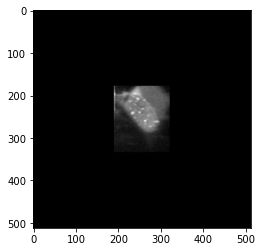

In [62]:
plt.imshow(image_stack[30,:,:,0], cmap='gray')

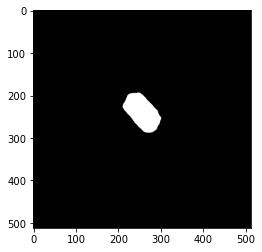

In [70]:
og_seg = np.load(data_path +"\\"+label_list[30])
plt.imshow(og_seg, cmap='gray')

In [71]:
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

In [76]:
img_prediction.shape
segmentation = img_prediction[30,:,:,]
segmentation = segmentation[:,:,1]
segmentation.shape

(512, 512)

<Figure size 432x288 with 0 Axes>

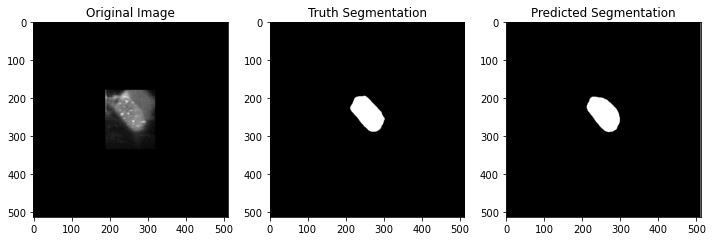

In [83]:
img_prediction_30 = img_prediction[30,:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[30,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

In [94]:
def visualise_data(x, y):
  n=1
  dim = 10
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

TypeError: tuple indices must be integers or slices, not tuple

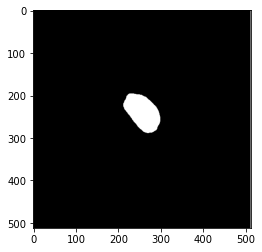

In [97]:
contours = measure.find_contours(segmentation, 0.8)
fig, ax = plt.subplots()
ax.imshow(segmentation, cmap=plt.cm.gray)

for contour in contours:
    #ax.imshow(image_stack[30,:,:,0], cmap="gray")
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=4)

contours = measure.find_contours(og_seg, .8)
for contour in enumerate(contours):
    ax.plot(contour[:,1], contour[:,0], color='#f03ee4', lw=4)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Prediction on UAB Dataset

In [7]:
data_path = r'C:\Users\UAB\data\UAB\AllNPY'
images = gather_images(data_path)

In [8]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [9]:
image_names = images[0:31]
image_stack = np.empty((32,512,512,1))
label_list = []
for i in range(len(image_names)):
    image = np.load(data_path +"\\"+images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(images[i][:-5] + 'K.npy')
    label_list.append(label_match)

print(image_stack.shape)
print(label_list)

(32, 512, 512, 1)
['407132_0_10_L_0_K.npy', '407132_0_10_L_1_K.npy', '407132_0_10_L_2_K.npy', '407132_0_10_L_3_K.npy', '407132_0_10_L_4_K.npy', '407132_0_10_L_5_K.npy', '407132_0_10_L_6_K.npy', '407132_0_10_L_7_K.npy', '407132_0_10_L_8_K.npy', '407132_0_10_L_9_K.npy', '407132_0_10_R_0_K.npy', '407132_0_10_R_1_K.npy', '407132_0_10_R_2_K.npy', '407132_0_10_R_3_K.npy', '407132_0_10_R_4_K.npy', '407132_0_10_R_5_K.npy', '407132_0_10_R_6_K.npy', '407132_0_10_R_7_K.npy', '407132_0_10_R_8_K.npy', '407132_0_10_R_9_K.npy', '407132_1_10_L_0_K.npy', '407132_1_10_L_1_K.npy', '407132_1_10_L_2_K.npy', '407132_1_10_L_3_K.npy', '407132_1_10_L_4_K.npy', '407132_1_10_L_5_K.npy', '407132_1_10_L_6_K.npy', '407132_1_10_L_7_K.npy', '407132_1_10_L_8_K.npy', '407132_1_10_L_9_K.npy', '407132_1_10_R_0_K.npy']


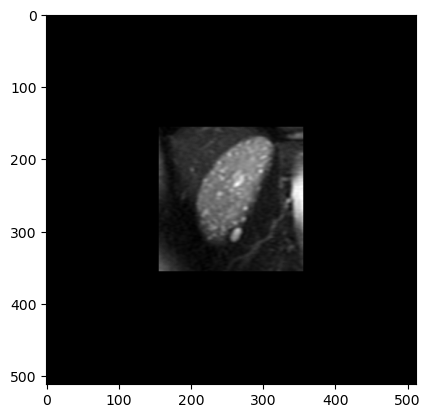

In [14]:
plt.imshow(image_stack[5,:,:,0], cmap='gray')

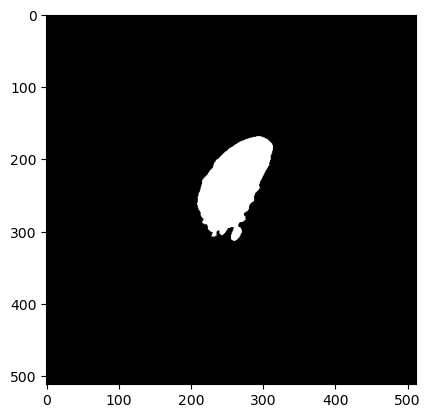

In [16]:
og_seg = np.load(data_path +"\\"+label_list[5])
plt.imshow(og_seg, cmap='gray')

In [17]:
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

In [18]:
img_prediction.shape
segmentation = img_prediction[5,:,:,]
segmentation = segmentation[:,:,1]
segmentation.shape

(512, 512)

<Figure size 640x480 with 0 Axes>

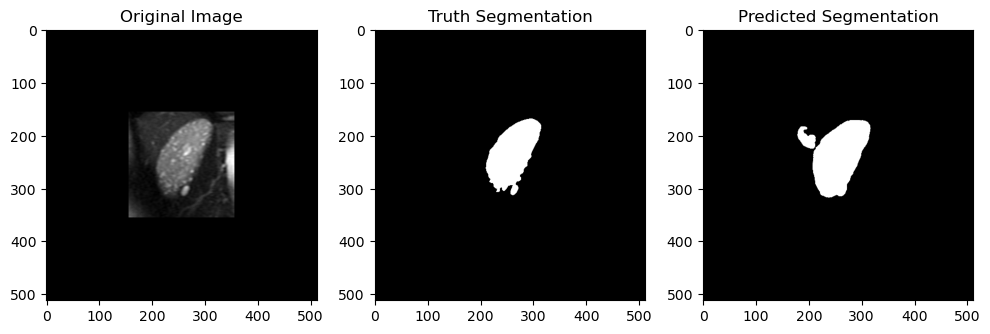

In [19]:
img_prediction_30 = img_prediction[5,:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[5,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

<Figure size 640x480 with 0 Axes>

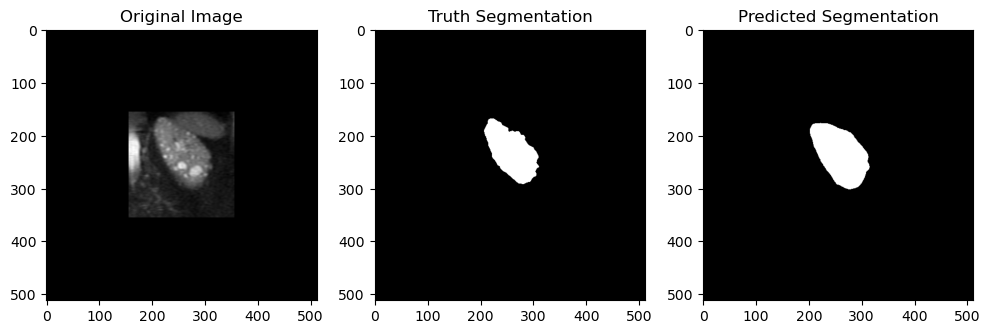

In [22]:
n=16
og_seg = np.load(data_path +"\\"+label_list[n])
segmentation = img_prediction[n,:,:,]
segmentation = segmentation[:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[n,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

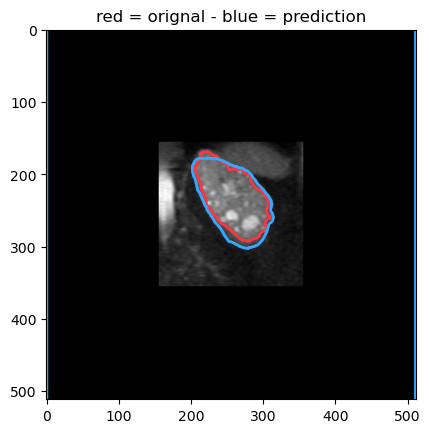

In [40]:

    fig, ax = plt.subplots()
    ax.imshow(image_stack[n,:,:,0], cmap=plt.cm.gray)

    contours = measure.find_contours(og_seg, 0.8)
    for j,contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
        contours = measure.find_contours(segmentation, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)

    ax.axis('image')
    ax.title.set_text('red = orignal - blue = prediction')

In [41]:
def visualize_predicition(image_stack, n):
    fig, ax = plt.subplots()
    ax.imshow(image_stack[n,:,:,0], cmap=plt.cm.gray)
    og_seg = np.load(data_path +"\\"+label_list[n])
    segmentation = img_prediction[n,:,:,]
    segmentation = segmentation[:,:,1]

    contours = measure.find_contours(og_seg, 0.8)
    for j,contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
        contours = measure.find_contours(segmentation, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)

    ax.axis('image')
    ax.title.set_text('red is orignal - blue is prediction')

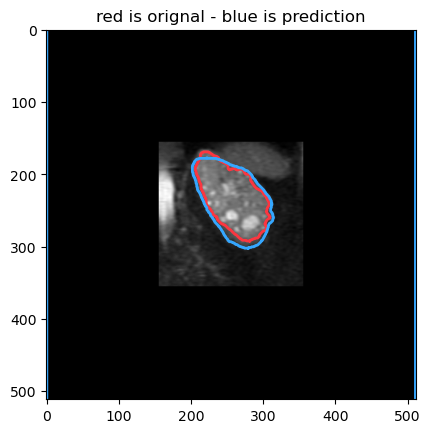

In [43]:
visualize_predicition(image_stack, 16)